# Data Augmentation using GANs for Traffic signs Classification


## Step 0: Load the data

Load the traffic signs data from the pickle files

In [1]:
# Load pickled data
import pickle
import numpy as np

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
n_classes = len(np.unique(y_train))

## Step 1: Dataset Summary & Exploration

In [2]:
print()
print("Image data shape: {}".format(X_train[0].shape))
print()
print("Number of training examples:   {} samples".format(len(X_train)))
print("Number of validation examples: {} samples".format(len(X_validation)))
print("Number of testing examples:    {} samples".format(len(X_test)))
print("Number of classes:             {} classes".format(n_classes))


Image data shape: (32, 32, 3)

Number of training examples:   34799 samples
Number of validation examples: 4410 samples
Number of testing examples:    12630 samples
Number of classes:             43 classes


### Visualize Data

View distribution of the data.

{0: 180, 1: 1980, 2: 2010, 3: 1260, 4: 1770, 5: 1650, 6: 360, 7: 1290, 8: 1260, 9: 1320, 10: 1800, 11: 1170, 12: 1890, 13: 1920, 14: 690, 15: 540, 16: 360, 17: 990, 18: 1080, 19: 180, 20: 300, 21: 270, 22: 330, 23: 450, 24: 240, 25: 1350, 26: 540, 27: 210, 28: 480, 29: 240, 30: 390, 31: 690, 32: 210, 33: 599, 34: 360, 35: 1080, 36: 330, 37: 180, 38: 1860, 39: 270, 40: 300, 41: 210, 42: 210}


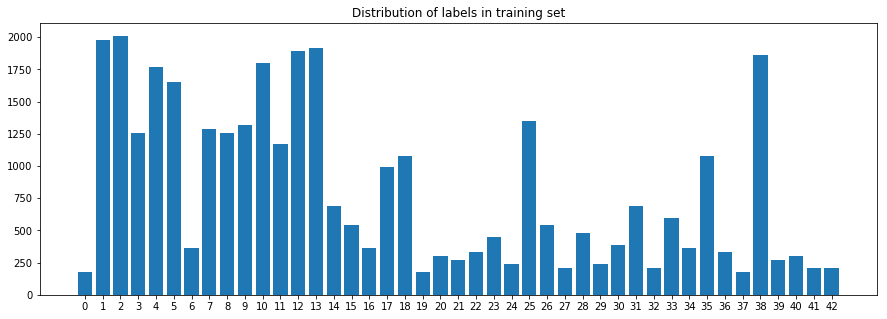

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

plt.rcParams["figure.figsize"] = [15, 5]
plt.bar(unique,counts)
axes = plt.gca()
axes.set_xticks(np.unique(y_train))

plt.title('Distribution of labels in training set')

signnames = pd.read_csv('signnames.csv')


View a sample from the training dataset.

Traffic signals


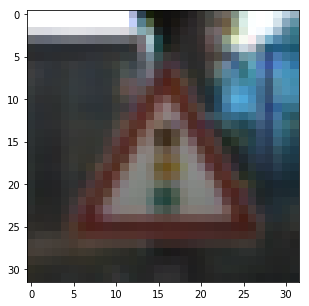

In [4]:
import random

def showImg(data):
    image = data[1240].squeeze()
    plt.figure()
    plt.imshow(image)
    print(signnames['SignName'][y_train[1240]])
    
showImg(X_train)

### Preprocess Data

### a. Normalization

Traffic signals


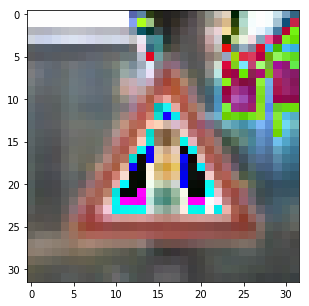

In [5]:
X_train = (X_train- 128.0 )/128.0
X_validation = (X_validation- 128.0 )/128.0
X_test = (X_test- 128.0 )/128.0

showImg(X_train)

### b. RGB -> Grayscale

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)
Traffic signals


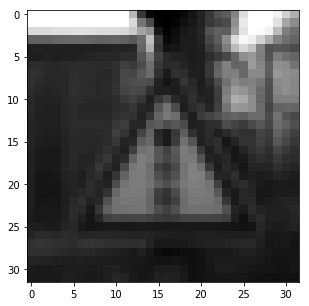

In [6]:
import cv2

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    img=img.astype(np.float32)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def grayscale_4d(X):
    X_gray = np.empty(X[:,:,:,0].shape)
    for i in range(len(X_gray)):
        X_gray[i] = grayscale(X[i])
    return(X_gray)

X_train_gray = grayscale_4d(X_train)
X_validation_gray = grayscale_4d(X_validation)
X_test_gray = grayscale_4d(X_test)

X_train_gray = np.reshape(X_train_gray,(X_train_gray.shape[0], 32, 32,1))
X_validation_gray = np.reshape(X_validation_gray,(X_validation_gray.shape[0], 32, 32,1))
X_test_gray = np.reshape(X_test_gray,(X_test_gray.shape[0], 32, 32,1))

X_train = np.copy(X_train_gray)
X_validation = np.copy(X_validation_gray)
X_test = np.copy(X_test_gray)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

image = X_train[1240].squeeze()

plt.figure()
plt.imshow(image,cmap='gray')
print(signnames['SignName'][y_train[1240]])

## Step 2: Model architecture

### Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.


In [7]:
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128

###  Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

In [8]:
from tensorflow.contrib.layers import flatten

KEEP_PROB = 0.5

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Store layers weight & bias 
    # The shape of the filter weight is (height, width, input_depth, output_depth)
    # The shape of the filter bias is (output_depth,) 
    # The shape of the stride for each dimension (batch_size, height, width, depth)
    weights = {
        'wc1': tf.Variable(tf.random_normal(shape=(5, 5, 1, 6),mean = mu, stddev = sigma)),
        'wc2': tf.Variable(tf.random_normal(shape=(5, 5, 6, 16),mean = mu, stddev = sigma)),
        'wd1': tf.Variable(tf.random_normal(shape=(5*5*16, 120),mean = mu, stddev = sigma)),
        'wd2': tf.Variable(tf.random_normal(shape=(120, 84),mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.random_normal(shape=(84, n_classes),mean = mu, stddev = sigma))}

    biases = {
        'bc1': tf.Variable(tf.zeros(6)),
        'bc2': tf.Variable(tf.zeros(16)),
        'bd1': tf.Variable(tf.zeros(120)),
        'bd2': tf.Variable(tf.zeros(84)),
        'out': tf.Variable(tf.zeros(n_classes))}    
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1, k=2)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2, k=2)

    # Flatten. Input = 5x5x16. Output = 400.
    conv2 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(conv2, weights['wd1']), biases['bd1'])
    
    # Activation.
    fc1 = tf.nn.relu(fc1)
    
    fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    
    # Activation.
    fc2 = tf.nn.relu(fc2)

    fc2 = tf.nn.dropout(fc2, keep_prob=keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return logits

### Features and Labels
Train LeNet to classify German Traffic signs data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [9]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

### Training Pipeline
Create a training pipeline that uses the model to classify traffic signs data.


In [10]:
rate = 0.002

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.


In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model


In [12]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:KEEP_PROB})
         
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        test_accuracy = evaluate(X_test, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.770
Validation Accuracy = 0.710
Test Accuracy = 0.715

EPOCH 2 ...
Training Accuracy = 0.904
Validation Accuracy = 0.841
Test Accuracy = 0.861

EPOCH 3 ...
Training Accuracy = 0.940
Validation Accuracy = 0.896
Test Accuracy = 0.892

EPOCH 4 ...
Training Accuracy = 0.959
Validation Accuracy = 0.905
Test Accuracy = 0.913

EPOCH 5 ...
Training Accuracy = 0.965
Validation Accuracy = 0.917
Test Accuracy = 0.916

EPOCH 6 ...
Training Accuracy = 0.972
Validation Accuracy = 0.931
Test Accuracy = 0.920

EPOCH 7 ...
Training Accuracy = 0.981
Validation Accuracy = 0.935
Test Accuracy = 0.926

EPOCH 8 ...
Training Accuracy = 0.986
Validation Accuracy = 0.945
Test Accuracy = 0.935

EPOCH 9 ...
Training Accuracy = 0.986
Validation Accuracy = 0.950
Test Accuracy = 0.932

EPOCH 10 ...
Training Accuracy = 0.987
Validation Accuracy = 0.951
Test Accuracy = 0.928

EPOCH 11 ...
Training Accuracy = 0.988
Validation Accuracy = 0.945
Test Accuracy = 0.932

EPOCH 

## Step 3: Test a Model on New Images

### Load and Output the Images

C:\Users\saran\AppData\Local\conda\conda\envs\IntroToTensorFlow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


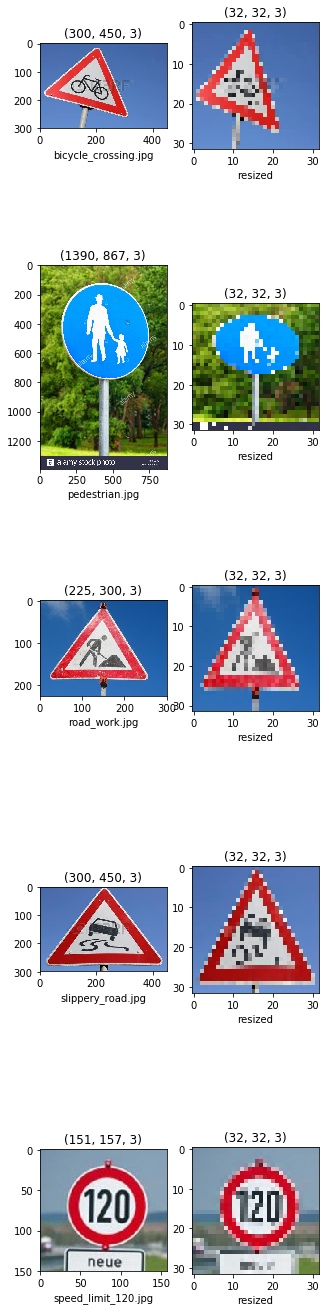

In [13]:
from os import listdir
from os.path import isfile, join
import matplotlib.image as mpimg
import skimage.data
import skimage.transform

mypath = './Test'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

i = 0
test_data = np.zeros([5,32,32,3])    
plotnum=1
fig = plt.figure(figsize=(5, 25))
ind = 0
for img in onlyfiles:
    image = mpimg.imread(mypath+'/'+img)
    fig.add_subplot(5, 2, plotnum)
    plt.title(image.shape)
    plt.xlabel(img)
    plt.imshow(image)
    ind+=1
    plotnum+=1
        
    image = skimage.transform.resize(image, (32, 32,3))
    fig.add_subplot(5, 2, plotnum)
    plt.title(image.shape)
    plt.xlabel("resized")
    plt.imshow(image)
    ind+=1
    plotnum+=1
    test_data[i] = (np.array(image))
    i = i+1
plt.show()


### Predict the Sign Type for Each Image

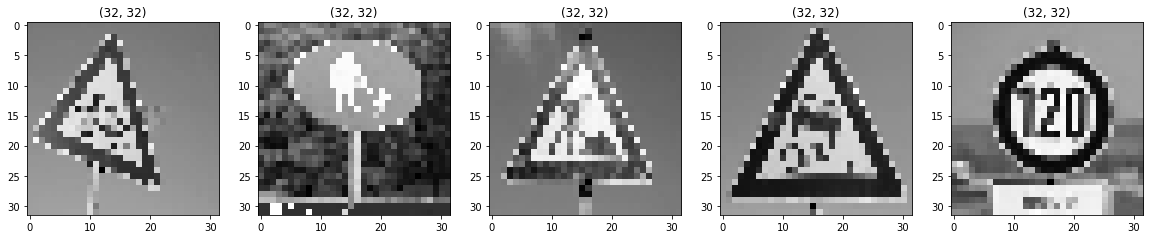

In [14]:
test_data_gray = grayscale_4d(test_data)

test_data_gray = np.reshape(test_data_gray,(test_data_gray.shape[0], 32, 32,1))
test_data = np.copy(test_data_gray)

plotnum=1
fig = plt.figure(figsize=(20, 15))  
for img in test_data:
    img = img.squeeze()
    fig.add_subplot(1, 5, plotnum)
    plt.title(img.shape)
    plt.imshow(img,cmap='gray')
    plotnum = plotnum + 1

INFO:tensorflow:Restoring parameters from .\lenet
[40 35 25 23  8]


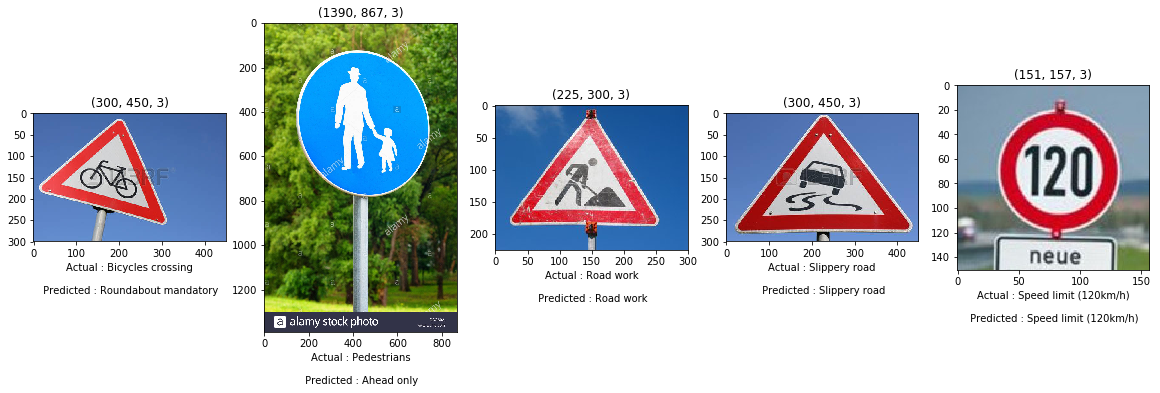

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predicted_y = sess.run(tf.argmax(logits, 1), feed_dict={x: test_data, keep_prob: 1.})
    print(predicted_y)

i = 0
plotnum=1
actual_y = [29,27,25,23,8]
fig = plt.figure(figsize=(20, 15))    
files =[f for f in listdir(mypath) if isfile(join(mypath, f))]
for img in files:
    fig.add_subplot(1, 5, plotnum)
    image = mpimg.imread(mypath+'/'+img)
    plt.title(image.shape)
    plt.xlabel('Actual : '+signnames['SignName'][actual_y[i]]+'\n\n Predicted : '+ signnames['SignName'][predicted_y[i]])
    plt.imshow(image)
    i = i+1
    plotnum = plotnum + 1


### Analyze Performance

In [18]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_data_accuracy = evaluate(test_data, actual_y)
    print(test_data_accuracy)

INFO:tensorflow:Restoring parameters from .\lenet
0.600000023842
